# Distributed Training with Hugging Face Sentiment Classification and Batch Transform
__Binary Classification with `Trainer` and `sst2` dataset, using Distributed Training and Batch Transform__

---

This notebook's CI test result for us-west-2 is as follows. CI test results in other regions can be found at the end of the notebook.

![This us-west-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://h75twx4l60.execute-api.us-west-2.amazonaws.com/sagemaker-nb/us-west-2/advanced_functionality|sentiment_parallel_batch|huggingface_sentiment_parallel_batch.ipynb)

---

## Runtime

This notebook takes approximately 60 minutes to run.

## Contents

1. [Introduction](#Introduction)  
2. [Development environment and permissions](#Development-environment-and-permissions)
    1. [Installation](#Installation)  
    2. [Development environment](#Development-environment)  
    3. [Permissions](#Permissions)
3. [Pre-processing](#Pre-processing)
    1. [Download the dataset](#Download-the-dataset)
    1. [Tokenize sentences](#Tokenize-sentences)  
    2. [Upload data to sagemaker_session_bucket](#Upload-data-to-sagemaker_session_bucket)  
4. [Fine-tune the model and start a SageMaker training job](#Fine-tune-the-model-and-start-a-SageMaker-training-job)
    1. [Enabling Debugger in Estimator object](#Enabling-Debugger-in-Estimator-object)
    1. [Create an Estimator and start a training job](#Create-an-Estimator-and-start-a-training-job)  
5. [Run Batch Transform after training a model](#Run-Batch-Transform-after-training-a-model)
    1. [Generate dummy data](#Generate-dummy-data)
    2. [Run the Batch Transform job](#Run-the-Batch-Transform-job)
    3. [Compare the dummy data to the predicted sentiments](#Compare-the-dummy-data-to-the-predicted-sentiments)

## Introduction

This notebook walks you through an end-to-end binary text classification example, whilst using [SageMaker Distributed Training](https://docs.aws.amazon.com/sagemaker/latest/dg/distributed-training.html) for the training step, and [SageMaker Batch Transform](https://docs.aws.amazon.com/sagemaker/latest/dg/batch-transform.html) for inference. If you are looking for an example notebook that trains on a single instances and uses a real-time model endpoint, please visit [Hugging Face Sentiment Classification](https://github.com/aws/amazon-sagemaker-examples/blob/b07198857bbfcf5b85c8a59357e12c49ccb91f5c/introduction_to_applying_machine_learning/huggingface_sentiment_classification/huggingface_sentiment.ipynb).

This notebook uses Hugging Face's `transformers` library with a custom Amazon sagemaker-sdk extension to fine-tune using data parallelism and a pre-trained transformer on binary text classification. The pre-trained model is fine-tuned using the `sst2` dataset. The notebook then runs batch inference on generated dummy data, before analyzing the results. To get started, we need to set up the environment with a few prerequisite steps for permissions, configurations, and a few others.

This notebook is adapted from two of Hugging Face's notebooks: [HuggingFace Sagemaker-sdk - Getting Started Demo](https://github.com/huggingface/notebooks/blob/main/sagemaker/01_getting_started_pytorch/sagemaker-notebook.ipynb) and [HuggingFace Sagemaker-sdk - training with custom metrics](https://github.com/huggingface/notebooks/blob/main/sagemaker/06_sagemaker_metrics/sagemaker-notebook.ipynb). These are provided here courtesy of Hugging Face.

<i>NOTE: You can run this notebook in SageMaker Studio, a SageMaker notebook instance, or your local machine. This notebook was tested in a notebook instance using the `conda\_pytorch\_p39`
    kernel.</i>


## Development environment and permissions 

### Installation

_*Note:* We install the required libraries from Hugging Face and AWS. You also need PyTorch, if you haven't installed it already._

In [ ]:
!pip install "sagemaker==2.187.0" "transformers==4.33.2" "datasets==2.14.5" "s3fs==2023.6.0" "awscli==1.29.17" "accelerate==0.23.0" "ipywidgets==7.1.1" --upgrade

### Development environment 

In [ ]:
import sagemaker.huggingface

### Permissions

_If you are going to use SageMaker in a local environment, you need access to an IAM Role with the required permissions for SageMaker. You can read more at [SageMaker Roles](https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-roles.html)._

In [4]:
import sagemaker

sess = sagemaker.Session()
# The SageMaker session bucket is used for uploading data, models and logs
# SageMaker will automatically create this bucket if it doesn't exist
sagemaker_session_bucket = None
if sagemaker_session_bucket is None and sess is not None:
    # Set to default bucket if a bucket name is not given
    sagemaker_session_bucket = sess.default_bucket()

role = sagemaker.get_execution_role()
sess = sagemaker.Session(default_bucket=sagemaker_session_bucket)

print(f"Role arn: {role}")
print(f"Bucket: {sess.default_bucket()}")
print(f"Region: {sess.boto_region_name}")

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
Role arn: arn:aws:iam::000000000000:role/sam2userprofilesagemakerrole
Bucket: sagemaker-us-east-1-000000000000
Region: us-east-1


## Pre-processing

We use the `datasets` library to pre-process the `sst2` dataset (Stanford Sentiment `Treebank`). After pre-processing, the dataset is uploaded to the `sagemaker_session_bucket` for use within the training job. The [sst2](https://nlp.stanford.edu/sentiment/index.html) dataset consists of 67349 training samples and _ testing samples of highly polar movie reviews.

### Download the dataset

In [5]:
from datasets import Dataset
from transformers import AutoTokenizer
import pandas as pd

# Tokenizer used in pre-processing
tokenizer_name = "distilbert-base-uncased"

# S3 key prefix for the data
s3_prefix = "DEMO-sentiment/datasets/sst2"

# Download the SST2 data from s3
!curl https://sagemaker-example-files-prod-us-east-1.s3.amazonaws.com/datasets/text/SST2/sst2.test > ./sst2.test
!curl https://sagemaker-example-files-prod-us-east-1.s3.amazonaws.com/datasets/text/SST2/sst2.train > ./sst2.train
!curl https://sagemaker-example-files-prod-us-east-1.s3.amazonaws.com/datasets/text/SST2/sst2.val > ./sst2.val

curl: /opt/conda/lib/libcurl.so.4: no version information available (required by curl)
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  189k  100  189k    0     0  2536k      0 --:--:-- --:--:-- --:--:-- 2554k
curl: /opt/conda/lib/libcurl.so.4: no version information available (required by curl)
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 3716k  100 3716k    0     0  10.2M      0 --:--:-- --:--:-- --:--:-- 10.1M
curl: /opt/conda/lib/libcurl.so.4: no version information available (required by curl)
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 94916  100 94916    0     0   297k      0 --:--:-- --:--:-- --:--:--  299k


### Tokenize sentences

In [ ]:
# Download tokenizer
tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)


# Tokenizer helper function
def tokenize(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True)


# Load dataset
test_df = pd.read_csv("sst2.test", sep="delimiter", header=None, engine="python", names=["line"])
train_df = pd.read_csv("sst2.train", sep="delimiter", header=None, engine="python", names=["line"])

test_df[["label", "text"]] = test_df["line"].str.split(" ", n=1, expand=True)
train_df[["label", "text"]] = train_df["line"].str.split(" ", n=1, expand=True)

test_df.drop("line", axis=1, inplace=True)
train_df.drop("line", axis=1, inplace=True)

test_df["label"] = pd.to_numeric(test_df["label"], downcast="integer")
train_df["label"] = pd.to_numeric(train_df["label"], downcast="integer")

train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

# Tokenize dataset
train_dataset = train_dataset.map(tokenize, batched=True)
test_dataset = test_dataset.map(tokenize, batched=True)

# Set format for pytorch
train_dataset = train_dataset.rename_column("label", "labels")
train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

test_dataset = test_dataset.rename_column("label", "labels")
test_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

In [7]:
train_df

,label,text
0,0,hide new secretions from the parental units
1,0,"contains no wit , only labored gags"
2,1,that loves its characters and communicates som...
3,0,remains utterly satisfied to remain the same t...
4,0,on the worst revenge-of-the-nerds clichés the ...
...,...,...
67344,1,a delightful comedy
67345,0,"anguish , anger and frustration"
67346,1,"at achieving the modest , crowd-pleasing goals..."
67347,1,a patient viewer


### Upload data to `sagemaker_session_bucket`

After processing the `datasets`, we upload the dataset to S3.

In [ ]:
from s3fs import S3FileSystem

s3 = S3FileSystem(storage_options="s3")

# save train_dataset to s3
training_input_path = f"s3://{sess.default_bucket()}/{s3_prefix}/train/input"
train_dataset.save_to_disk(training_input_path)

# save test_dataset to s3
test_input_path = f"s3://{sess.default_bucket()}/{s3_prefix}/test/input"
test_dataset.save_to_disk(test_input_path)

## Fine-tune the model and start a SageMaker training job

In order to create a SageMaker training job, we need a `HuggingFace` Estimator. The Estimator handles end-to-end Amazon SageMaker training and deployment tasks. In an Estimator, we define which fine-tuning script should be used as `entry_point`, which `instance_type` should be used, which `hyperparameters` are passed in, as well as the following:



```python
hf_estimator = HuggingFace(entry_point="train.py",
                            source_dir="./scripts",
                            base_job_name="huggingface-sdk-extension",
                            instance_type="ml.p3.2xlarge",
                            instance_count=1,
                            transformers_version="4.4",
                            pytorch_version="1.6",
                            py_version="py36",
                            role=role,
                            hyperparameters = {"epochs": 1,
                                               "train_batch_size": 32,
                                               "model_name":"distilbert-base-uncased"
                                                })
```

When we create a SageMaker training job, SageMaker takes care of starting and managing all the required EC2 instances for us with the `huggingface` container, uploads the provided fine-tuning script `train.py`, and downloads the data from the `sagemaker_session_bucket` into the container at `/opt/ml/input/data`. Then, it starts the training job by running:

```python
/opt/conda/bin/python train.py --epochs 1 --model_name distilbert-base-uncased --train_batch_size 32
```

The `hyperparameters` defined in the `HuggingFace` estimator are passed in as named arguments. 

SageMaker provides useful properties about the training environment through various environment variables, including the following:

* `SM_MODEL_DIR`: A string representing the path where the training job writes the model artifacts to. After training, artifacts in this directory are uploaded to S3 for model hosting.

* `SM_NUM_GPUS`: An integer representing the number of GPUs available to the host.

* `SM_CHANNEL_XXXX:` A string representing the path to the directory that contains the input data for the specified channel. For example, if you specify two input channels in the Hugging Face estimator's `fit()` call, named `train` and `test`, the environment variables `SM_CHANNEL_TRAIN` and `SM_CHANNEL_TEST` are set.


To run the training job locally, you can define `instance_type="local"` or `instance_type="local_gpu"` for GPU usage.

_Note: local mode is not supported in SageMaker Studio._


In [ ]:
!pygmentize ./scripts/train.py

### Enabling Debugger in Estimator object


#### DebuggerHookConfig

Enabling Amazon SageMaker Debugger in training job can be accomplished by adding its configuration into Estimator object constructor:

```python
from sagemaker.debugger import DebuggerHookConfig, CollectionConfig

estimator = Estimator(
    ...,
    debugger_hook_config = DebuggerHookConfig(
        s3_output_path="s3://{bucket_name}/{location_in_bucket}",  # Required
        collection_configs=[
            CollectionConfig(
                name="weights",
                parameters={
                    "save_interval": "10"
                }
            )
        ]
    )
)
```
Here, the `DebuggerHookConfig` object instructs `Estimator` what data we are interested in.
Two parameters are provided in the example:

- `s3_output_path`: it points to S3 bucket/path where we intend to store our debugging tensors.
  Amount of data saved depends on multiple factors, major ones are: training job / data set / model / frequency of saving tensors.
  This bucket should be in your AWS account, and you should have full access control over it.
  **Important Note**: this s3 bucket should be originally created in the same region where your training job will be running, otherwise you might run into problems with cross region access.

- `collection_configs`: it enumerates named collections of tensors we want to save.
  Collections are a convenient way to organize relevant tensors under same umbrella to make it easy to navigate them during analysis.
  In this particular example, you are instructing Amazon SageMaker Debugger that you are interested in a single collection named `metrics`.
  We also instructed Amazon SageMaker Debugger to save metrics every 10 iteration.
  See [Collection](https://github.com/awslabs/sagemaker-debugger/blob/master/docs/api.md#collection) documentation for all parameters that are supported by Collections and `DebuggerConfig` documentation for more details about all parameters `DebuggerConfig` supports.
  
#### Training Script
  
You may have noticed that the training script has been adapted to work with SageMaker Debugger. We have done so here, but note that this not is required for certain versions of PyTorch and TensorFlow. See [Supported Frameworks and Algorithms](https://docs.aws.amazon.com/sagemaker/latest/dg/debugger-supported-frameworks.html) for more information. 

In the above training script we have defined a class for Debugger. This allows us to pass a Debugger hook in the Trainer as part of the training process. To do this, we are using the [`SMDebug` client library](https://docs.aws.amazon.com/sagemaker/latest/dg/debugger-bring-your-own-container.html). For more information, please see the associated page for [PyTorch](https://github.com/awslabs/sagemaker-debugger/blob/master/docs/pytorch.md). Further instructions can also be found in [Adapt Your PyTorch Training Script](https://docs.aws.amazon.com/sagemaker/latest/dg/debugger-modify-script-pytorch.html).
  
#### Rules

Enabling Rules in training job can be accomplished by adding the `rules` configuration into the Estimator object constructor.

- `rules`: This parameter will accept a list of rules you wish to evaluate against the tensors output by this training job.
  For rules, Amazon SageMaker Debugger supports two types:
  - SageMaker Rules: These are rules specially curated by the data science and engineering teams in Amazon SageMaker which you can opt to evaluate against your training job.
  - Custom Rules: You can optionally choose to write your own rule as a Python source file and have it evaluated against your training job.
    To provide Amazon SageMaker Debugger to evaluate this rule, you would have to provide the S3 location of the rule source and the evaluator image.

In this example, you will use an Amazon SageMaker's LossNotDecreasing rule, which helps you identify if you are running into a situation where the training loss is not going down.

```python
from sagemaker.debugger import rule_configs, Rule

estimator = Estimator(
    ...,
    rules=[
        Rule.sagemaker(
            rule_configs.loss_not_decreasing(),
            rule_parameters={
                "collection_names": "losses",
                "num_steps": "10",
            },
        ),
    ],
)
```

- `rule_parameters`: In this parameter, you provide the runtime values of the parameter in your constructor.
  You can still choose to pass in other values which may be necessary for your rule to be evaluated.
  In this example, you will use Amazon SageMaker's LossNotDecreasing rule to monitor the `metircs` collection.
  The rule will alert you if the tensors in `metrics` has not decreased for more than 10 steps.

### Use SageMaker Distributed Training Data Parallelism

[Amazon SageMaker's distributed library](https://docs.aws.amazon.com/sagemaker/latest/dg/distributed-training.html) supports various distributed training options for deep learning tasks such as computer vision (CV) and natural language processing (NLP). With SageMaker’s distributed training libraries, you can run highly scalable and cost-effective custom data parallel and model parallel deep learning training jobs. Here, we will be using the distributed library for NLP [data parallelism](https://docs.aws.amazon.com/sagemaker/latest/dg/data-parallel.html). The SageMaker data parallelism library extends SageMaker training capabilities on deep learning models with near-linear scaling efficiency, achieving fast time-to-train with minimal code changes. It is available through the AWS deep learning containers for the TensorFlow, PyTorch, and HuggingFace frameworks within the SageMaker training platform.

As per the [Hugging Face documentation](https://huggingface.co/docs/sagemaker/train#data-parallelism), The Hugging Face [Trainer](https://huggingface.co/docs/transformers/main_classes/trainer) supports SageMaker’s data parallelism library. If your training script uses the Trainer API, you only need to define the distribution parameter in the Hugging Face Estimator:

```python
distribution = {'smdistributed':{'dataparallel':{ 'enabled': True }}}
```

Please see further information in [Launch a Training job](https://docs.aws.amazon.com/sagemaker/latest/dg/data-parallel-use-api.html).

**Instance types**

`SMDataParallel` supports larger compute instances that have 8 GPUs per node:
1. ml.p3.16xlarge
1. ml.p3dn.24xlarge
1. ml.p4d.24xlarge
1. ml.p4de.24xlarge

For specs of the instance types, see the Accelerated Computing section in the [Amazon EC2 Instance Types page](https://aws.amazon.com/ec2/instance-types/). For information about instance pricing, see [Amazon SageMaker Pricing](https://aws.amazon.com/sagemaker/pricing/). In this example, we will be using a ml.p3.16xlarge.

Note, if when training you encounter a `ResourceLimitExceeded` error message, it is possible that you may need to [request a service quota increase for SageMaker resources](https://docs.aws.amazon.com/sagemaker/latest/dg/regions-quotas.html#service-limit-increase-request-procedure).

**Instance count**

To get the best performance and the most out of `SMDataParallel`, you should use at least 2 instances, but you can also use 1 for testing this example.

### Create an Estimator and start a training job

Now we'll create the estimator. For this we will include:
1. The IAM role to use
1. The Training instance type and count
1. The `HuggingFace` algorithm container and script
1. The hyperparameters which are passed to the training job
1. The Distribution strategy that allows us to perform data parallelism
1. The `DebuggerHookConfig` object which saves the specific tensors for debugging
1. The `LossNotDecreasing` rule which detects when the loss is not decreasing in value at an adequate rate

And then we set the algorithm hyperparameters, as well as specify the `.fit()` function which specifies the S3 location for output data.  In this case we have both a training and validation set which are passed in. Note that in the `DebuggerHookConfig` we are specifying weights, biases, and gradients. A fourth collection, losses, is also saved by default when using SageMaker Debugger with PyTorch.

We also specify and pass to the Estimator metric definitions, with associated regex patterns. This will be used to parse the job logs and extract metrics, which will be used for visualization after the job completes.

In [10]:
from sagemaker.huggingface import HuggingFace
from sagemaker.pytorch import PyTorch

# Hyperparameters which are passed into the training job
hyperparameters = {
    "epochs": 2,
    "train_batch_size": 32,
    "model_name": "distilbert-base-uncased",
}

In [11]:
metric_definitions = [
    {"Name": "loss", "Regex": "'loss': ([0-9]+(.|e\-)[0-9]+),?"},
    {"Name": "learning_rate", "Regex": "'learning_rate': ([0-9]+(.|e\-)[0-9]+),?"},
    {"Name": "train_loss", "Regex": "'train_loss': ([0-9\\.]+)"},
    {"Name": "eval_loss", "Regex": "'eval_loss': ([0-9]+(.|e\-)[0-9]+),?"},
    {"Name": "eval_accuracy", "Regex": "'eval_accuracy': ([0-9]+(.|e\-)[0-9]+),?"},
    {"Name": "eval_f1", "Regex": "'eval_f1': ([0-9]+(.|e\-)[0-9]+),?"},
    {"Name": "eval_precision", "Regex": "'eval_precision': ([0-9]+(.|e\-)[0-9]+),?"},
    {"Name": "eval_recall", "Regex": "'eval_recall': ([0-9]+(.|e\-)[0-9]+),?"},
    {"Name": "eval_runtime", "Regex": "'eval_runtime': ([0-9]+(.|e\-)[0-9]+),?"},
    {
        "Name": "eval_samples_per_second",
        "Regex": "'eval_samples_per_second': ([0-9]+(.|e\-)[0-9]+),?",
    },
    {"Name": "epoch", "Regex": "'epoch': ([0-9]+(.|e\-)[0-9]+),?"},
]

In [12]:
from sagemaker.debugger import rule_configs, Rule, DebuggerHookConfig, CollectionConfig
from sagemaker.estimator import Estimator

save_interval = 5

hf_estimator = HuggingFace(
    entry_point="train.py",
    source_dir="./scripts",
    instance_type="ml.p3.16xlarge",
    instance_count=2,
    role=role,
    transformers_version="4.28.1",
    pytorch_version="2.0.0",
    datasets_version="2.14.5",
    py_version="py310",
    hyperparameters=hyperparameters,
    metric_definitions=metric_definitions,
    s3_output_path=training_input_path + "/files",
    enable_sagemaker_metrics=True,
    distribution={
        "smdistributed": {"dataparallel": {"enabled": True}}
    },  # Training using SMDataParallel Distributed Training Framework
    debugger_hook_config=DebuggerHookConfig(
        s3_output_path=f"s3://{sess.default_bucket()}/{s3_prefix}/train/debug",  # Required
        collection_configs=[
            CollectionConfig(name="weights", parameters={"save_interval": str(save_interval)}),
            CollectionConfig(name="biases", parameters={"save_interval": str(save_interval)}),
            CollectionConfig(name="gradients", parameters={"save_interval": str(save_interval)}),
        ],
    ),
    rules=[
        Rule.sagemaker(
            rule_configs.loss_not_decreasing(),
            rule_parameters={
                "collection_names": "metrics",
                "num_steps": str(save_interval * 2),
            },
        ),
    ],
)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


In [13]:
# Start the training job with the uploaded dataset as input
hf_estimator.fit(
    {"train": training_input_path, "test": test_input_path},
    # This is a fire and forget event. By setting wait=False, you submit the job to run in the background.
    # Amazon SageMaker starts one training job and release control to next cells in the notebook.
    # Follow this notebook to see status of the training job.
    wait=False,
)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.


Using provided s3_resource


INFO:sagemaker:Creating training-job with name: huggingface-pytorch-training-2023-10-13-12-15-16-551


#### Result

As a result of the below command, Amazon SageMaker starts one training job and one rule job for you. The first one is the job that produces the tensors to be analyzed. The second one analyzes the tensors to check if it is not decreasing at any point during training.

Check the status of the training job below. After your training job is started, Amazon SageMaker starts a rule-execution job to run the LossNotDecreasing rule.

Note that the next cell blocks until the rule execution job ends. You can stop it at any point to proceed to the rest of the notebook. Once it says Rule Evaluation Status is Started, and shows the `RuleEvaluationJobArn`, you can look at the status of the rule being monitored.

Note that the execution of the below cell will take around 30 minutes.

In [14]:
import time
from time import gmtime, strftime

# Below command will give the status of training job
job_name = hf_estimator.latest_training_job.name
client = hf_estimator.sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName=job_name)
rule_job_summary = hf_estimator.latest_training_job.rule_job_summary()
rule_evaluation_status = rule_job_summary[0]["RuleEvaluationStatus"]
print("Training job name: " + job_name)
print(description["TrainingJobStatus"])

if description["TrainingJobStatus"] != "Completed" or rule_evaluation_status not in [
    "IssuesFound",
    "NoIssuesFound",
    "Failed",
    "Stopped",
]:
    while (
        description["SecondaryStatus"] not in ["Training", "Completed", "Failed", "Stopped"]
    ) or (rule_job_summary[0]["RuleEvaluationStatus"] == "InProgress"):
        description = client.describe_training_job(TrainingJobName=job_name)
        primary_status = description["TrainingJobStatus"]
        secondary_status = description["SecondaryStatus"]
        rule_job_summary = hf_estimator.latest_training_job.rule_job_summary()
        rule_evaluation_status = rule_job_summary[0]["RuleEvaluationStatus"]
        print(
            "{}: {}, {}, {}".format(
                strftime("%X", gmtime()),
                primary_status,
                secondary_status,
                rule_evaluation_status,
            )
        )
        time.sleep(15)

Training job name: huggingface-pytorch-training-2023-10-13-12-15-16-551
InProgress
12:15:17: InProgress, Starting, InProgress
12:15:32: InProgress, Starting, InProgress
12:15:47: InProgress, Starting, InProgress
12:16:02: InProgress, Starting, InProgress
12:16:18: InProgress, Starting, InProgress
12:16:33: InProgress, Starting, InProgress
12:16:48: InProgress, Starting, InProgress
12:17:03: InProgress, Starting, InProgress
12:17:18: InProgress, Starting, InProgress
12:17:33: InProgress, Downloading, InProgress
12:17:48: InProgress, Downloading, InProgress
12:18:03: InProgress, Downloading, InProgress
12:18:18: InProgress, Training, InProgress
12:18:33: InProgress, Training, InProgress
12:18:48: InProgress, Training, InProgress
12:19:03: InProgress, Training, InProgress
12:19:19: InProgress, Training, InProgress
12:19:34: InProgress, Training, InProgress
12:19:49: InProgress, Training, InProgress
12:20:04: InProgress, Training, InProgress
12:20:19: InProgress, Training, InProgress
12:20

### Check the status of the Rule Evaluation Job

To get the rule evaluation job that Amazon SageMaker started for you, run the command below. The results show you the `RuleConfigurationName`, `RuleEvaluationJobArn`, `RuleEvaluationStatus`, `StatusDetails`, and `RuleEvaluationJobArn`. If the model parameters meet a rule evaluation condition, the rule execution job throws a client error with `RuleEvaluationConditionMet`.

The logs of the rule evaluation job are available in the CloudWatch Log Stream `/aws/sagemaker/ProcessingJobs` with `RuleEvaluationJobArn`.

In [15]:
hf_estimator.latest_training_job.rule_job_summary()[0]

{'RuleConfigurationName': 'LossNotDecreasing',
 'RuleEvaluationJobArn': 'arn:aws:sagemaker:us-east-1:000000000000:processing-job/huggingface-pytorch-traini-LossNotDecreasing-bf572596',
 'RuleEvaluationStatus': 'NoIssuesFound',
 'LastModifiedTime': datetime.datetime(2023, 10, 13, 12, 47, 35, 970000, tzinfo=tzlocal())}

## Data Analysis - Manual

Now that you've trained the system, you can analyze the data. Here, you focus on after-the-fact analysis.

You import a basic analysis library, which defines the concept of trial, which represents a single training run.

In [16]:
from smdebug.trials import create_trial

path = hf_estimator.latest_job_debugger_artifacts_path()
smdebug_trial = create_trial(path)

[2023-10-13 12:48:00.363 pytorch-1-1-ml-t3-medi-auto-shutdo-64985dc1451db92d1184eceef135:354 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2023-10-13 12:48:00.388 pytorch-1-1-ml-t3-medi-auto-shutdo-64985dc1451db92d1184eceef135:354 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-000000000000/DEMO-sentiment/datasets/sst2/train/debug/huggingface-pytorch-training-2023-10-13-12-15-16-551/debug-output


In [17]:
# cell 18
from smdebug.trials import create_trial

description = client.describe_training_job(TrainingJobName=job_name)
s3_output_path = hf_estimator.latest_job_debugger_artifacts_path()

# This is where we create a Trial object that allows access to saved tensors.
trial = create_trial(s3_output_path)

[2023-10-13 12:48:05.137 pytorch-1-1-ml-t3-medi-auto-shutdo-64985dc1451db92d1184eceef135:354 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-000000000000/DEMO-sentiment/datasets/sst2/train/debug/huggingface-pytorch-training-2023-10-13-12-15-16-551/debug-output


You can list all the tensors that you know something about. Each one of these names is the name of a tensor. The name is a combination of the feature name, and whether it is a weight, bias, gradient, or loss value.

In [18]:
trial.tensor_names()

[2023-10-13 12:48:07.607 pytorch-1-1-ml-t3-medi-auto-shutdo-64985dc1451db92d1184eceef135:354 INFO trial.py:197] Training has ended, will refresh one final time in 1 sec.
[2023-10-13 12:48:08.628 pytorch-1-1-ml-t3-medi-auto-shutdo-64985dc1451db92d1184eceef135:354 INFO trial.py:210] Loaded all steps


['DistilBertForSequenceClassification_classifier.bias',
 'DistilBertForSequenceClassification_classifier.weight',
 'DistilBertForSequenceClassification_distilbert.embeddings.LayerNorm.bias',
 'DistilBertForSequenceClassification_distilbert.embeddings.LayerNorm.weight',
 'DistilBertForSequenceClassification_distilbert.embeddings.position_embeddings.weight',
 'DistilBertForSequenceClassification_distilbert.embeddings.word_embeddings.weight',
 'DistilBertForSequenceClassification_distilbert.transformer.layer.0.attention.k_lin.bias',
 'DistilBertForSequenceClassification_distilbert.transformer.layer.0.attention.k_lin.weight',
 'DistilBertForSequenceClassification_distilbert.transformer.layer.0.attention.out_lin.bias',
 'DistilBertForSequenceClassification_distilbert.transformer.layer.0.attention.out_lin.weight',
 'DistilBertForSequenceClassification_distilbert.transformer.layer.0.attention.q_lin.bias',
 'DistilBertForSequenceClassification_distilbert.transformer.layer.0.attention.q_lin.wei

For each tensor, ask for the steps where you have data. In this case, every five steps

In [19]:
trial.tensor("DistilBertForSequenceClassification_classifier.weight").values()

{0: array([[-0.02830256, -0.0265185 , -0.01370953, ...,  0.0072067 ,
          0.04160934, -0.02341137],
        [-0.00357319, -0.00753774, -0.00013769, ...,  0.01535792,
          0.01157053,  0.00667914]], dtype=float32),
 5: array([[-0.02830195, -0.02651859, -0.01371048, ...,  0.00720627,
          0.04160879, -0.02341189],
        [-0.00357379, -0.00753766, -0.00013674, ...,  0.01535836,
          0.01157108,  0.00667966]], dtype=float32),
 10: array([[-0.02829978, -0.02651711, -0.0137126 , ...,  0.00720387,
          0.04160659, -0.0234125 ],
        [-0.00357597, -0.00753913, -0.00013463, ...,  0.01536076,
          0.01157328,  0.00668027]], dtype=float32),
 15: array([[-0.02829562, -0.02651677, -0.01371575, ...,  0.00719948,
          0.04160358, -0.02341062],
        [-0.00358013, -0.00753947, -0.00013148, ...,  0.01536515,
          0.0115763 ,  0.0066784 ]], dtype=float32),
 20: array([[-0.02829102, -0.0265165 , -0.01372071, ...,  0.00719336,
          0.04159779, -0.0234135

These saved collections of weights, biases, gradients and losses into S3 allow us to analyze these over the course of the training job, allowing us to refine the model where necessary.

Additionally, we can produce a table that produces the metrics recorded from the `metrics_definitions` dictionary we created earlier, as well as visualize them over time. Here, we visualize the loss, as well as the evaluation loss, accuracy, and precision.

In [20]:
from sagemaker import TrainingJobAnalytics

# Captured metrics can be accessed as a Pandas dataframe
df = TrainingJobAnalytics(training_job_name=hf_estimator.latest_training_job.name).dataframe()
df.head(15)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


,timestamp,metric_name,value
0,0.0,loss,0.656600
1,60.0,loss,0.348333
2,120.0,loss,0.240250
3,180.0,loss,0.196567
4,0.0,learning_rate,2.000002
5,60.0,learning_rate,3.066670
6,120.0,learning_rate,1.200005
7,180.0,learning_rate,2.400000
8,0.0,train_loss,0.347536
9,0.0,eval_loss,0.279655


In [21]:
from matplotlib import pyplot as plt
import seaborn as sns

plt.rcParams["figure.figsize"] = [20, 5]

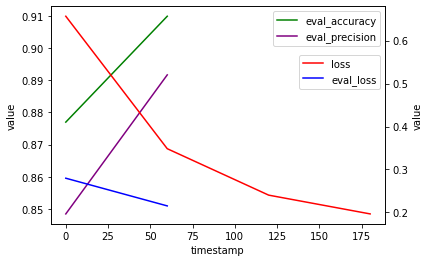

In [22]:
evals = df[df.metric_name.isin(["eval_accuracy", "eval_precision"])]
losses = df[df.metric_name.isin(["loss", "eval_loss"])]

ax = sns.lineplot(
    x="timestamp", y="value", data=evals, hue="metric_name", palette=["green", "purple"]
)

ax2 = plt.twinx()

sns.lineplot(
    x="timestamp",
    y="value",
    data=losses,
    hue="metric_name",
    palette=["red", "blue"],
    ax=ax2,
)

ax.legend(bbox_to_anchor=(1, 1))
ax2.legend(bbox_to_anchor=(1, 0.8))

## Run Batch Transform after training a model 

After you've trained the model, you can use [Amazon SageMaker Batch Transform](https://docs.aws.amazon.com/sagemaker/latest/dg/batch-transform.html) to perform inferences with the model. In Batch Transform you provide your inference data as a S3 URI and SageMaker will care of downloading it, running the prediction and uploading the results afterwards to S3 again.

If you've trained the model using the **HuggingFace estimator**, you can invoke `transformer()` method to create a transform job for a model based on the training job.

```python
batch_job = huggingface_estimator.transformer(
    instance_count=1,
    instance_type='ml.c5.2xlarge',
    strategy='SingleRecord')


batch_job.transform(
    data='s3://s3-uri-to-batch-data',
    content_type='application/json',    
    split_type='Line')
```
For more details about what can be specified here, see [API docs](https://sagemaker.readthedocs.io/en/stable/overview.html#sagemaker-batch-transform).

### Generate dummy data

We generate 5000 dummy reviews and upload them to S3 as a json lines file. We are creating this over two files, as we will specify two instances for our batch transform job.

In [23]:
# Making dummy data
from sagemaker.s3 import S3Uploader, s3_path_join
import random
import csv
import json

batch_reviews_path = f"s3://{sess.default_bucket()}/{s3_prefix}/batch_transform"


def make_dummy_data(file_id, review_count):
    outputs = []
    file_name = f"batch_reviews{file_id}.jsonl"

    # Generating 5000 dummy movie reviews
    for i in range(review_count):
        # Generating a fake review text
        review = ""
        review += random.choice(
            [
                "This movie was ",
                "I thought that the movie was ",
                "In my opinion, this was ",
                "Overall, this movie was ",
            ]
        )
        review += random.choice(
            [
                "great",
                "terrible",
                "good",
                "bad",
                "excellent",
                "awful",
                "amazing",
                "horrible",
            ]
        )
        review += random.choice([".", "!", "...", "?", "!!", "??"]) + " "
        review += "This is "
        review += random.choice(
            [
                "because of the ",
                "as a reslt of the ",
                "in consequence of the ",
                "as a direct result of the ",
                "for the following reason: The ",
            ]
        )
        review += random.choice(
            [
                "storyline.",
                "plot.",
                "cast.",
                "characters.",
                "movie quality.",
                "director.",
                "atmosphere.",
            ]
        )
        outputs.append({"inputs": review})

    # Write the review to a jsonl file
    with open(file_name, "w", encoding="utf-8") as f:
        for output in outputs:
            f.write(json.dumps(output) + "\n")

    # uploads a given file to S3.
    s3_file_uri = S3Uploader.upload(file_name, batch_reviews_path)

In [24]:
make_dummy_data(1, 2500)
make_dummy_data(2, 2500)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


### Run the Batch Transform job

We now run the batch transform job, specifying the model data from the estimator, and the IAM Role, as well as the instance count, type, and output path. The `Strategy` parameter refers to the number of records to include in a mini-batch for an HTTP inference request. A record is a single unit of input data that inference can be made on. For example, a single line in a JSON lines file is a record, which is what we are using here. Setting Strategy to `SingleRecord` means that one line in the JSON lines file is used when making an HTTP invocation request to a container.

Note, if when running the below two cells you encounter a `ResourceLimitExceeded` error message, it is possible that you may need to [request a service quota increase for SageMaker resources](https://docs.aws.amazon.com/sagemaker/latest/dg/regions-quotas.html#service-limit-increase-request-procedure).

In [25]:
from sagemaker.huggingface.model import HuggingFaceModel

huggingface_model = HuggingFaceModel(
    model_data=hf_estimator.model_data,
    role=role,  # iam role with permissions to create an Endpoint
    transformers_version="4.26",  # transformers version used
    pytorch_version="1.13",  # pytorch version used
    py_version="py39",  # python version used
)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


In [26]:
# create Transformer to run our batch job

batch_job = huggingface_model.transformer(
    instance_count=2,
    instance_type="ml.p3.2xlarge",
    output_path=batch_reviews_path,  # we are using the same s3 path to save the output with the input
    strategy="SingleRecord",
)

# starts batch transform job and uses s3 data as input
batch_job.transform(
    data=f"{batch_reviews_path}",
    content_type="application/json",
    split_type="Line",
    logs=False,
)

INFO:sagemaker:Creating model with name: huggingface-pytorch-inference-2023-10-13-12-48-21-674
INFO:sagemaker:Creating transform job with name: huggingface-pytorch-inference-2023-10-13-12-48-22-496


..............................................................................................................................................!


### Compare the dummy data to the predicted sentiments

We then print 10 sentences and compare them to the labels from the batch transform job.

In [27]:
import json
from sagemaker.s3 import S3Downloader
from ast import literal_eval


def create_results(input_file):
    # creating s3 uri for result file -> input file + .out
    input_file = input_file
    output_file = input_file + ".out"
    output_path = s3_path_join(batch_reviews_path, output_file)

    # download file
    S3Downloader.download(output_path, ".")

    temp_batch_transform_result = []
    with open(output_file) as f:
        for line in f:
            # converts jsonline array to normal array
            line = "[" + line.replace("[", "").replace("]", ",") + "]"
            temp_batch_transform_result = literal_eval(line)

    data_temp = []
    with open(input_file) as f:
        for line in f:
            data_temp.append(json.loads(line))

    for i, line in enumerate(data_temp):
        temp_batch_transform_result[i]["text"] = line["inputs"]
        temp_batch_transform_result[i]["label"] = (
            "Positive" if temp_batch_transform_result[i]["label"] == "LABEL_1" else "Negative"
        )

    # print results
    return temp_batch_transform_result


batch_transform_result = create_results("batch_reviews1.jsonl")
batch_transform_result.extend(create_results("batch_reviews2.jsonl"))

print(json.dumps(batch_transform_result[:10], indent=4))

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
[
    {
        "label": "Positive",
        "score": 0.9912720322608948,
        "text": "Overall, this movie was good!! This is as a reslt of the movie quality."
    },
    {
        "label": "Positive",
        "score": 0.9834914803504944,
        "text": "This movie was excellent! This is in consequence of the plot."
    },
    {
        "label": "Positive",
        "score": 0.9931867122650146,
        "text": "Overall, this movie was great. This is because of the director."
    },
    {
        "label": "Positive",
        "score": 0.988024890422821,
        "text": "In my opinion, this was exc

We can see that the model appears fairly confident in classifying most of the above examples correctly. But is this true for all the generated test data? Let's find out by converting the data into a Pandas dataframe, and seeing the most and least confident inputs for both labels.

In [28]:
# df_results.sort_values('score', ascending=False)
df_results = pd.DataFrame(batch_transform_result)
pd.set_option("display.max_colwidth", None)

df_results[df_results["label"] == "Positive"].sort_values(
    "score", ascending=False
).drop_duplicates()

,label,score,text
812,Positive,0.995237,"Overall, this movie was amazing... This is as a reslt of the characters."
177,Positive,0.995105,"Overall, this movie was amazing... This is as a reslt of the director."
1352,Positive,0.995096,"Overall, this movie was amazing. This is as a reslt of the atmosphere."
1402,Positive,0.995032,"Overall, this movie was amazing... This is as a reslt of the cast."
4055,Positive,0.994958,"Overall, this movie was amazing. This is as a reslt of the characters."
...,...,...,...
3364,Positive,0.517768,I thought that the movie was good? This is in consequence of the director.
1484,Positive,0.517662,I thought that the movie was great? This is in consequence of the cast.
1662,Positive,0.512529,This movie was good?? This is as a direct result of the atmosphere.
3520,Positive,0.504030,"Overall, this movie was good?? This is in consequence of the cast."


In [29]:
df_results[df_results["label"] == "Negative"].sort_values(
    "score", ascending=False
).drop_duplicates()

,label,score,text
856,Negative,0.986685,"Overall, this movie was awful? This is in consequence of the plot."
4669,Negative,0.986495,This movie was horrible... This is for the following reason: The plot.
2452,Negative,0.986352,"Overall, this movie was awful. This is in consequence of the plot."
2450,Negative,0.986351,"Overall, this movie was awful. This is for the following reason: The plot."
4704,Negative,0.986324,This movie was awful. This is for the following reason: The plot.
...,...,...,...
2870,Negative,0.509259,This movie was amazing? This is in consequence of the plot.
4628,Negative,0.505962,"In my opinion, this was amazing?? This is for the following reason: The storyline."
3948,Negative,0.504660,This movie was great?? This is as a direct result of the director.
611,Negative,0.504233,"In my opinion, this was great?? This is for the following reason: The storyline."


We can see in fact that the model is struggling with a few examples, particularly where the text is punctuated with question marks. 
Finally, we create a box plot to visualize the distribution of the predictions for each label.

<AxesSubplot: xlabel='label', ylabel='score'>

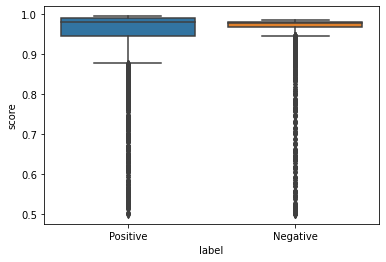

In [30]:
sns.boxplot(
    x="label",
    y="score",
    data=df_results,
)

We can see that the ranges and interquartile ranges for the positive label are fairly larger than for the negative label. This shows a larger variance in predictions for positive, which may need refining upon further training and hyperparameter optimization. Note though that because this test data is randomly generated, the box plot may differ in your case. One interesting exercise is to determine whether the positive label interquartile range is consistently larger than the negative label upon further generations of test data, and sending these to the model. This may help to determine whether the model is in general more consistently confident for negative label predictions.

## Extras

### Deploy an endpoint

To deploy the endpoint, call `deploy()` on the HuggingFace estimator object, passing in the desired number of instances and instance type.

In [31]:
predictor = hf_estimator.deploy(1, "ml.p3.2xlarge")

INFO:sagemaker:Creating model with name: huggingface-pytorch-training-2023-10-13-13-00-23-422
INFO:sagemaker:Creating endpoint-config with name huggingface-pytorch-training-2023-10-13-13-00-23-422
INFO:sagemaker:Creating endpoint with name huggingface-pytorch-training-2023-10-13-13-00-23-422


------------!

Then use the returned predictor object to perform inference.

In [32]:
sentiment_input = {"inputs": "I love using the new Inference DLC."}

predictor.predict(sentiment_input)

[{'label': 'LABEL_1', 'score': 0.9790288209915161}]

We see that the fine-tuned model classifies the test sentence "I love using the new Inference DLC." as having positive sentiment with 98% probability!

Finally, delete the endpoint.

In [33]:
predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: huggingface-pytorch-training-2023-10-13-13-00-23-422
INFO:sagemaker:Deleting endpoint with name: huggingface-pytorch-training-2023-10-13-13-00-23-422


### Estimator Parameters

In [34]:
print(f"Container image used for training job: \n{hf_estimator.image_uri}\n")
print(f"S3 URI where the trained model is located: \n{hf_estimator.model_data}\n")
print(f"Latest training job name for this estimator: \n{hf_estimator.latest_training_job.name}\n")

Container image used for training job: 
None

S3 URI where the trained model is located: 
s3://sagemaker-us-east-1-000000000000/huggingface-pytorch-training-2023-10-13-12-15-16-551/output/model.tar.gz

Latest training job name for this estimator: 
huggingface-pytorch-training-2023-10-13-12-15-16-551



In [ ]:
hf_estimator.sagemaker_session.logs_for_job(hf_estimator.latest_training_job.name)

### Attach a previous training job to an estimator

In SageMaker, you can attach a previous training job to an estimator to continue training, get results, etc.

In [36]:
from sagemaker.estimator import Estimator

# Uncomment the following lines and supply your training job name

# old_training_job_name = "<your-training-job-name>"
# hf_estimator_loaded = Estimator.attach(old_training_job_name)
# hf_estimator_loaded.model_data

## Notebook CI Test Results

This notebook was tested in multiple regions. The test results are as follows, except for us-west-2 which is shown at the top of the notebook.


![This us-east-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://h75twx4l60.execute-api.us-west-2.amazonaws.com/sagemaker-nb/us-east-1/advanced_functionality|sentiment_parallel_batch|huggingface_sentiment_parallel_batch.ipynb)

![This us-east-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://h75twx4l60.execute-api.us-west-2.amazonaws.com/sagemaker-nb/us-east-2/advanced_functionality|sentiment_parallel_batch|huggingface_sentiment_parallel_batch.ipynb)

![This us-west-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://h75twx4l60.execute-api.us-west-2.amazonaws.com/sagemaker-nb/us-west-1/advanced_functionality|sentiment_parallel_batch|huggingface_sentiment_parallel_batch.ipynb)

![This ca-central-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://h75twx4l60.execute-api.us-west-2.amazonaws.com/sagemaker-nb/ca-central-1/advanced_functionality|sentiment_parallel_batch|huggingface_sentiment_parallel_batch.ipynb)

![This sa-east-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://h75twx4l60.execute-api.us-west-2.amazonaws.com/sagemaker-nb/sa-east-1/advanced_functionality|sentiment_parallel_batch|huggingface_sentiment_parallel_batch.ipynb)

![This eu-west-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://h75twx4l60.execute-api.us-west-2.amazonaws.com/sagemaker-nb/eu-west-1/advanced_functionality|sentiment_parallel_batch|huggingface_sentiment_parallel_batch.ipynb)

![This eu-west-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://h75twx4l60.execute-api.us-west-2.amazonaws.com/sagemaker-nb/eu-west-2/advanced_functionality|sentiment_parallel_batch|huggingface_sentiment_parallel_batch.ipynb)

![This eu-west-3 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://h75twx4l60.execute-api.us-west-2.amazonaws.com/sagemaker-nb/eu-west-3/advanced_functionality|sentiment_parallel_batch|huggingface_sentiment_parallel_batch.ipynb)

![This eu-central-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://h75twx4l60.execute-api.us-west-2.amazonaws.com/sagemaker-nb/eu-central-1/advanced_functionality|sentiment_parallel_batch|huggingface_sentiment_parallel_batch.ipynb)

![This eu-north-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://h75twx4l60.execute-api.us-west-2.amazonaws.com/sagemaker-nb/eu-north-1/advanced_functionality|sentiment_parallel_batch|huggingface_sentiment_parallel_batch.ipynb)

![This ap-southeast-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://h75twx4l60.execute-api.us-west-2.amazonaws.com/sagemaker-nb/ap-southeast-1/advanced_functionality|sentiment_parallel_batch|huggingface_sentiment_parallel_batch.ipynb)

![This ap-southeast-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://h75twx4l60.execute-api.us-west-2.amazonaws.com/sagemaker-nb/ap-southeast-2/advanced_functionality|sentiment_parallel_batch|huggingface_sentiment_parallel_batch.ipynb)

![This ap-northeast-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://h75twx4l60.execute-api.us-west-2.amazonaws.com/sagemaker-nb/ap-northeast-1/advanced_functionality|sentiment_parallel_batch|huggingface_sentiment_parallel_batch.ipynb)

![This ap-northeast-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://h75twx4l60.execute-api.us-west-2.amazonaws.com/sagemaker-nb/ap-northeast-2/advanced_functionality|sentiment_parallel_batch|huggingface_sentiment_parallel_batch.ipynb)

![This ap-south-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://h75twx4l60.execute-api.us-west-2.amazonaws.com/sagemaker-nb/ap-south-1/advanced_functionality|sentiment_parallel_batch|huggingface_sentiment_parallel_batch.ipynb)

